# Eval 2: Gene-Level Analysis

This evaluation combines two complementary questions about per-gene prediction quality:

**Part A - Direction of Effect**: Even when magnitude is wrong, does the model get the direction right?
- Metrics: Accuracy, F1 for up/down/unchanged classes
- Story: Getting direction right is often more actionable than exact magnitude

**Part B - Top DEG Recovery**: Does the model identify which genes are most affected?
- Metrics: Precision@K, NDCG, overlap of top-K predicted vs. true DEGs
- Story: Recovering the right set of top DEGs is useful for hypothesis generation

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

from eval_common import EvalContext, update_eval_report

In [2]:
ctx = EvalContext()
results = ctx.run_test_inference()

using cpu
Input Bank (DNA): torch.Size([1250, 1536])
<All keys matched successfully>
Decoder loaded
found 4 shards for split test
loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0000.npz


Running inference:  26%|███████▋                      | 312/1213 [01:58<09:01,  1.66it/s]

loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0003.npz


Running inference:  48%|██████████████▌               | 588/1213 [04:26<05:10,  2.01it/s]

loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0001.npz


Running inference:  74%|██████████████████████▎       | 900/1213 [07:02<02:39,  1.96it/s]

loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0002.npz


Running inference: 100%|█████████████████████████████| 1213/1213 [09:22<00:00,  2.16it/s]


Aggregated 286 perturbations, 38816 samples


In [3]:
pert_ids = results['pert_ids']
mean_pred_deltas = results['mean_pred_deltas']
mean_real_deltas = results['mean_real_deltas']
n_genes = ctx.config['n_genes']

---
# Part A: Direction of Effect

Classify each gene's expression change as UP (+1), DOWN (-1), or UNCHANGED (0).

In [4]:
DIRECTION_THRESHOLD = 0.25

def classify_direction(delta, threshold=DIRECTION_THRESHOLD):
    direction = np.zeros_like(delta, dtype=np.int8)
    direction[delta >= threshold] = 1
    direction[delta <= -threshold] = -1
    return direction

DIRECTION_LABELS = {-1: 'DOWN', 0: 'UNCHANGED', 1: 'UP'}

## Threshold Analysis

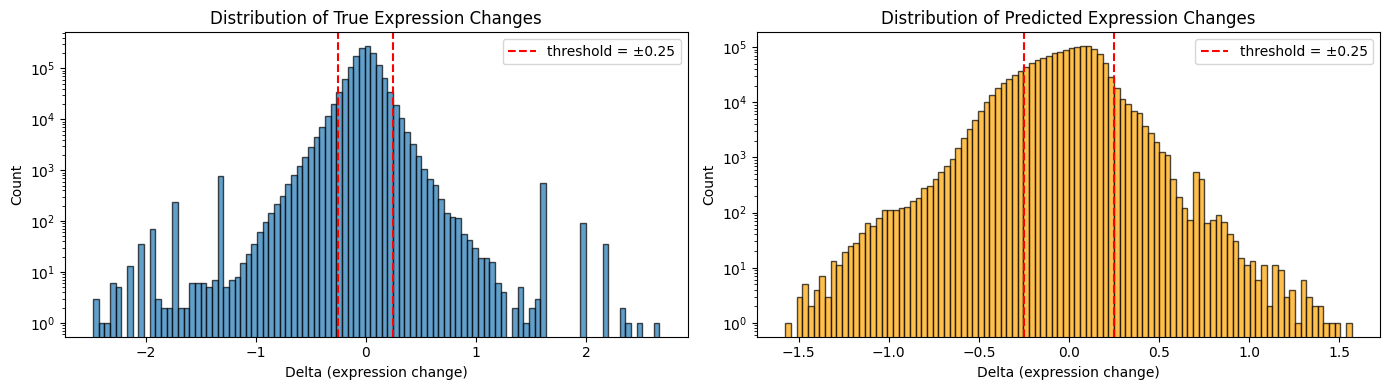

In [5]:
all_real = np.concatenate([mean_real_deltas[pid] for pid in pert_ids])
all_pred = np.concatenate([mean_pred_deltas[pid] for pid in pert_ids])

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(all_real, bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(-DIRECTION_THRESHOLD, color='red', linestyle='--', label=f'threshold = ±{DIRECTION_THRESHOLD}')
axes[0].axvline(DIRECTION_THRESHOLD, color='red', linestyle='--')
axes[0].set_xlabel('Delta (expression change)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of True Expression Changes')
axes[0].legend()
axes[0].set_yscale('log')

axes[1].hist(all_pred, bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(-DIRECTION_THRESHOLD, color='red', linestyle='--', label=f'threshold = ±{DIRECTION_THRESHOLD}')
axes[1].axvline(DIRECTION_THRESHOLD, color='red', linestyle='--')
axes[1].set_xlabel('Delta (expression change)')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Predicted Expression Changes')
axes[1].legend()
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

In [6]:
real_directions = classify_direction(all_real)
pred_directions = classify_direction(all_pred)

print(f'Class Balance at threshold = {DIRECTION_THRESHOLD}:')
print()
print('TRUE directions:')
for label_id, label_name in DIRECTION_LABELS.items():
    count = (real_directions == label_id).sum()
    pct = 100 * count / len(real_directions)
    print(f'  {label_name:>10}: {count:>10,} ({pct:>5.1f}%)')

print()
print('PREDICTED directions:')
for label_id, label_name in DIRECTION_LABELS.items():
    count = (pred_directions == label_id).sum()
    pct = 100 * count / len(pred_directions)
    print(f'  {label_name:>10}: {count:>10,} ({pct:>5.1f}%)')

Class Balance at threshold = 0.25:

TRUE directions:
        DOWN:     62,076 (  4.3%)
   UNCHANGED:  1,324,773 ( 92.6%)
          UP:     43,151 (  3.0%)

PREDICTED directions:
        DOWN:    186,714 ( 13.1%)
   UNCHANGED:  1,178,869 ( 82.4%)
          UP:     64,417 (  4.5%)


## Direction Metrics

In [7]:
all_pred_directions = []
all_real_directions = []

for pid in pert_ids:
    pred_dir = classify_direction(mean_pred_deltas[pid])
    real_dir = classify_direction(mean_real_deltas[pid])
    all_pred_directions.append(pred_dir)
    all_real_directions.append(real_dir)

all_pred_directions = np.concatenate(all_pred_directions)
all_real_directions = np.concatenate(all_real_directions)

In [8]:
overall_accuracy = accuracy_score(all_real_directions, all_pred_directions)
print(f'Overall Direction Accuracy: {overall_accuracy:.4f}')
print()
print('Classification Report:')
print(classification_report(all_real_directions, all_pred_directions, target_names=['DOWN', 'UNCHANGED', 'UP']))

Overall Direction Accuracy: 0.7989

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.14      0.44      0.22     62076
   UNCHANGED       0.94      0.84      0.89   1324773
          UP       0.07      0.11      0.09     43151

    accuracy                           0.80   1430000
   macro avg       0.39      0.46      0.40   1430000
weighted avg       0.88      0.80      0.83   1430000



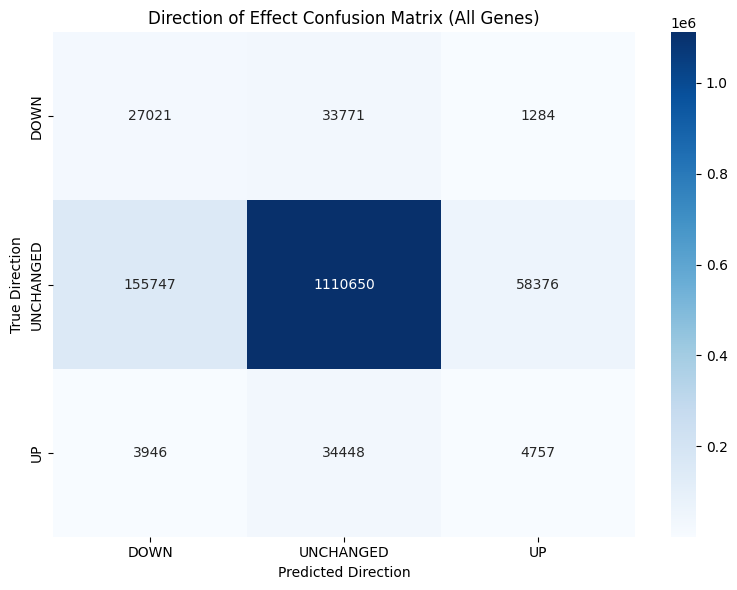

In [9]:
cm = confusion_matrix(all_real_directions, all_pred_directions, labels=[-1, 0, 1])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['DOWN', 'UNCHANGED', 'UP'],
            yticklabels=['DOWN', 'UNCHANGED', 'UP'])
plt.xlabel('Predicted Direction')
plt.ylabel('True Direction')
plt.title('Direction of Effect Confusion Matrix (All Genes)')
plt.tight_layout()
plt.show()

## Top DEG Direction Analysis

In [10]:
TOP_K_DIR = 50

top_deg_pred_directions = []
top_deg_real_directions = []

for pid in pert_ids:
    real_delta = mean_real_deltas[pid]
    pred_delta = mean_pred_deltas[pid]
    top_k_idx = np.argsort(np.abs(real_delta))[-TOP_K_DIR:]
    
    pred_dir = classify_direction(pred_delta[top_k_idx])
    real_dir = classify_direction(real_delta[top_k_idx])
    
    top_deg_pred_directions.append(pred_dir)
    top_deg_real_directions.append(real_dir)

top_deg_pred_directions = np.concatenate(top_deg_pred_directions)
top_deg_real_directions = np.concatenate(top_deg_real_directions)

top_deg_accuracy = accuracy_score(top_deg_real_directions, top_deg_pred_directions)
print(f'Top {TOP_K_DIR} DEG Direction Accuracy: {top_deg_accuracy:.4f}')
print()
print('Classification Report (Top DEGs):')
print(classification_report(top_deg_real_directions, top_deg_pred_directions, target_names=['DOWN', 'UNCHANGED', 'UP']))

Top 50 DEG Direction Accuracy: 0.3799

Classification Report (Top DEGs):
              precision    recall  f1-score   support

        DOWN       0.86      0.55      0.67      8069
   UNCHANGED       0.05      0.68      0.09       623
          UP       0.77      0.11      0.19      5608

    accuracy                           0.38     14300
   macro avg       0.56      0.44      0.32     14300
weighted avg       0.79      0.38      0.45     14300



## Direction Accuracy vs. Magnitude

In [11]:
all_magnitudes = []
all_correct = []

for pid in pert_ids:
    real_delta = mean_real_deltas[pid]
    pred_delta = mean_pred_deltas[pid]
    pred_dir = classify_direction(pred_delta)
    real_dir = classify_direction(real_delta)
    all_magnitudes.extend(np.abs(real_delta))
    all_correct.extend(pred_dir == real_dir)

all_magnitudes = np.array(all_magnitudes)
all_correct = np.array(all_correct)

magnitude_bins = [0, 0.25, 0.5, 1.0, 1.5, 2.0, np.inf]
bin_labels = ['0-0.25', '0.25-0.5', '0.5-1.0', '1.0-1.5', '1.5-2.0', '2.0+']

direction_bin_accuracies = []
direction_bin_counts = []

for i in range(len(magnitude_bins) - 1):
    mask = (all_magnitudes >= magnitude_bins[i]) & (all_magnitudes < magnitude_bins[i+1])
    if mask.sum() > 0:
        direction_bin_accuracies.append(all_correct[mask].mean())
        direction_bin_counts.append(mask.sum())
    else:
        direction_bin_accuracies.append(0)
        direction_bin_counts.append(0)

print('Direction Accuracy by Magnitude Bin:')
for label, acc, count in zip(bin_labels, direction_bin_accuracies, direction_bin_counts):
    print(f'  {label}: {acc:.4f} (n={count:,})')

Direction Accuracy by Magnitude Bin:
  0-0.25: 0.8384 (n=1,324,773)
  0.25-0.5: 0.2768 (n=93,566)
  0.5-1.0: 0.4214 (n=9,608)
  1.0-1.5: 0.8349 (n=957)
  1.5-2.0: 0.9445 (n=991)
  2.0+: 0.8952 (n=105)


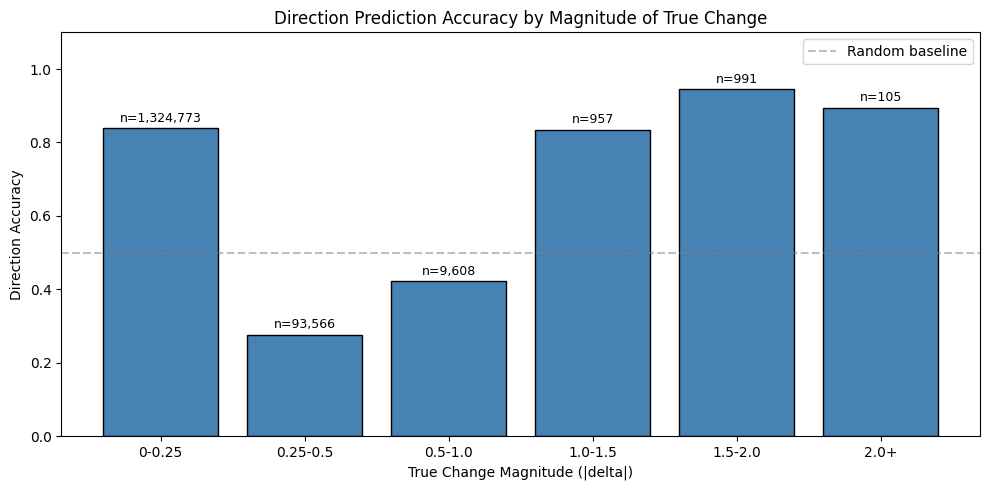

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(bin_labels))
bars = ax.bar(x, direction_bin_accuracies, color='steelblue', edgecolor='black')

for i, (bar, count) in enumerate(zip(bars, direction_bin_counts)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'n={count:,}', ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(bin_labels)
ax.set_xlabel('True Change Magnitude (|delta|)')
ax.set_ylabel('Direction Accuracy')
ax.set_title('Direction Prediction Accuracy by Magnitude of True Change')
ax.set_ylim(0, 1.1)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Random baseline')
ax.legend()

plt.tight_layout()
plt.show()

---
# Part B: Top DEG Recovery

For each perturbation, rank genes by predicted |delta| and measure overlap with true top DEGs.

In [13]:
def precision_at_k(pred_ranking, true_ranking, k):
    pred_top_k = set(pred_ranking[:k])
    true_top_k = set(true_ranking[:k])
    return len(pred_top_k & true_top_k) / k

def dcg_at_k(relevances, k):
    relevances = np.array(relevances)[:k]
    if len(relevances) == 0:
        return 0.0
    discounts = np.log2(np.arange(2, len(relevances) + 2))
    return np.sum(relevances / discounts)

def ndcg_at_k(pred_ranking, true_ranking, k):
    true_top_k_set = set(true_ranking[:k])
    relevances = [1 if gene in true_top_k_set else 0 for gene in pred_ranking[:k]]
    dcg = dcg_at_k(relevances, k)
    ideal_relevances = [1] * min(k, len(true_top_k_set))
    idcg = dcg_at_k(ideal_relevances, k)
    return dcg / idcg if idcg > 0 else 0.0

In [14]:
K_VALUES = [10, 20, 50, 100]

deg_results = {k: {'precision': [], 'ndcg': []} for k in K_VALUES}
overlap_counts = {k: [] for k in K_VALUES}

for pid in pert_ids:
    pred_delta = mean_pred_deltas[pid]
    real_delta = mean_real_deltas[pid]
    
    pred_ranking = np.argsort(np.abs(pred_delta))[::-1]
    true_ranking = np.argsort(np.abs(real_delta))[::-1]
    
    for k in K_VALUES:
        deg_results[k]['precision'].append(precision_at_k(pred_ranking, true_ranking, k))
        deg_results[k]['ndcg'].append(ndcg_at_k(pred_ranking, true_ranking, k))
        overlap_counts[k].append(len(set(pred_ranking[:k]) & set(true_ranking[:k])))

In [15]:
print('TOP DEG RECOVERY METRICS')
print('=' * 70)
print()
print(f'{"K":>6} | {"Precision@K":>12} | {"NDCG@K":>12} | {"Overlap":>12} | {"vs Random":>10}')
print('-' * 70)

for k in K_VALUES:
    prec = np.mean(deg_results[k]['precision'])
    ndcg = np.mean(deg_results[k]['ndcg'])
    overlap = np.mean(overlap_counts[k])
    random_baseline = k * k / n_genes
    improvement = overlap / random_baseline if random_baseline > 0 else 0
    print(f'{k:>6} | {prec:>12.4f} | {ndcg:>12.4f} | {overlap:>10.1f}/{k} | {improvement:>9.1f}x')

TOP DEG RECOVERY METRICS

     K |  Precision@K |       NDCG@K |      Overlap |  vs Random
----------------------------------------------------------------------
    10 |       0.0122 |       0.0130 |        0.1/10 |       6.1x
    20 |       0.0222 |       0.0219 |        0.4/20 |       5.6x
    50 |       0.0565 |       0.0549 |        2.8/50 |       5.7x
   100 |       0.0859 |       0.0874 |        8.6/100 |       4.3x


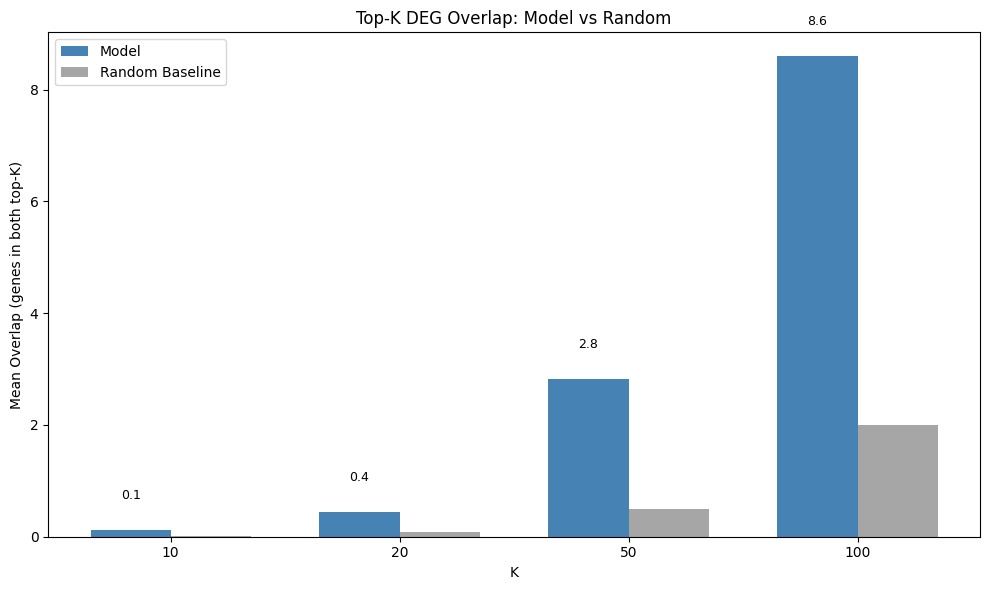

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

k_vals = K_VALUES
mean_overlaps = [np.mean(overlap_counts[k]) for k in k_vals]
random_expected = [k * k / n_genes for k in k_vals]

x = np.arange(len(k_vals))
width = 0.35

bars1 = ax.bar(x - width/2, mean_overlaps, width, label='Model', color='steelblue')
bars2 = ax.bar(x + width/2, random_expected, width, label='Random Baseline', color='gray', alpha=0.7)

ax.set_xlabel('K')
ax.set_ylabel('Mean Overlap (genes in both top-K)')
ax.set_title('Top-K DEG Overlap: Model vs Random')
ax.set_xticks(x)
ax.set_xticklabels(k_vals)
ax.legend()

for bar, val in zip(bars1, mean_overlaps):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

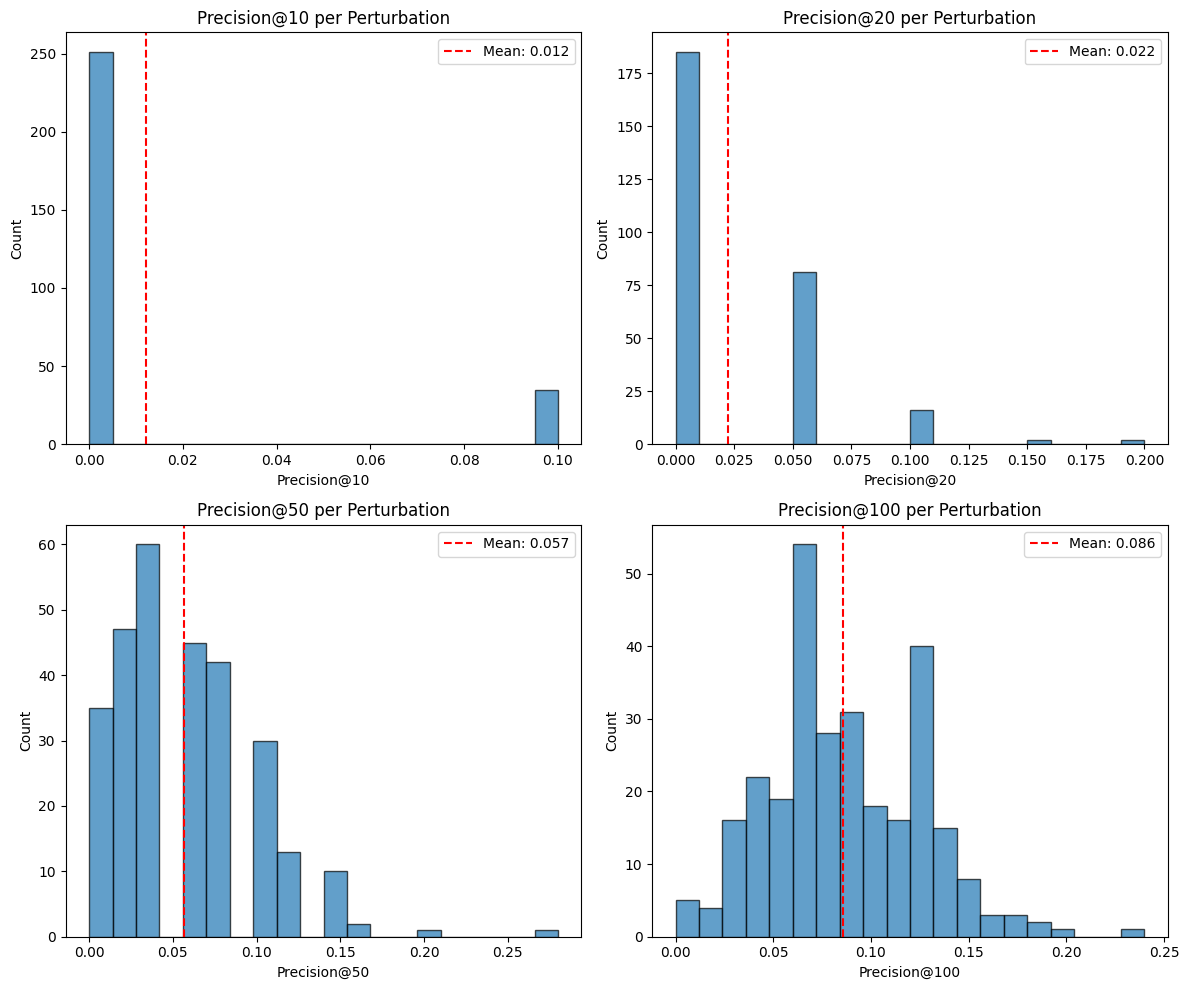

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, k in enumerate([10, 20, 50, 100]):
    ax = axes[idx // 2, idx % 2]
    ax.hist(deg_results[k]['precision'], bins=20, edgecolor='black', alpha=0.7)
    mean_prec = np.mean(deg_results[k]['precision'])
    ax.axvline(mean_prec, color='red', linestyle='--', label=f'Mean: {mean_prec:.3f}')
    ax.set_xlabel(f'Precision@{k}')
    ax.set_ylabel('Count')
    ax.set_title(f'Precision@{k} per Perturbation')
    ax.legend()

plt.tight_layout()
plt.show()

---
# Combined Benchmark Results

In [18]:
print('='*70)
print('EVAL 2: GENE-LEVEL ANALYSIS - BENCHMARK RESULTS')
print('='*70)
print()
print('CONFIGURATION')
print(f'  Perturbations (test): {len(pert_ids)}')
print(f'  Genes: {n_genes}')
print(f'  Direction threshold: {DIRECTION_THRESHOLD}')
print()
print('PART A: DIRECTION OF EFFECT')
print(f'  All genes accuracy:      {overall_accuracy:.4f}')
print(f'  Top {TOP_K_DIR} DEGs accuracy:     {top_deg_accuracy:.4f}')
print()
print('  Accuracy by magnitude:')
for label, acc, count in zip(bin_labels, direction_bin_accuracies, direction_bin_counts):
    bar = '█' * int(acc * 20)
    print(f'    {label:>8}: {acc:.2f} {bar} (n={count:,})')
print()
print('PART B: TOP DEG RECOVERY')
for k in K_VALUES:
    prec = np.mean(deg_results[k]['precision'])
    overlap = np.mean(overlap_counts[k])
    random_baseline = k * k / n_genes
    improvement = overlap / random_baseline if random_baseline > 0 else 0
    print(f'  @{k:>3}: Precision={prec:.3f}, Overlap={overlap:.1f}/{k} ({improvement:.1f}x random)')

EVAL 2: GENE-LEVEL ANALYSIS - BENCHMARK RESULTS

CONFIGURATION
  Perturbations (test): 286
  Genes: 5000
  Direction threshold: 0.25

PART A: DIRECTION OF EFFECT
  All genes accuracy:      0.7989
  Top 50 DEGs accuracy:     0.3799

  Accuracy by magnitude:
      0-0.25: 0.84 ████████████████ (n=1,324,773)
    0.25-0.5: 0.28 █████ (n=93,566)
     0.5-1.0: 0.42 ████████ (n=9,608)
     1.0-1.5: 0.83 ████████████████ (n=957)
     1.5-2.0: 0.94 ██████████████████ (n=991)
        2.0+: 0.90 █████████████████ (n=105)

PART B: TOP DEG RECOVERY
  @ 10: Precision=0.012, Overlap=0.1/10 (6.1x random)
  @ 20: Precision=0.022, Overlap=0.4/20 (5.6x random)
  @ 50: Precision=0.057, Overlap=2.8/50 (5.7x random)
  @100: Precision=0.086, Overlap=8.6/100 (4.3x random)


In [19]:
update_eval_report('eval_2_gene_level_analysis', {
    'config': {
        'test_perturbations': len(pert_ids),
        'genes': n_genes,
        'direction_threshold': DIRECTION_THRESHOLD
    },
    'direction_of_effect': {
        'all_genes_accuracy': float(overall_accuracy),
        'top50_degs_accuracy': float(top_deg_accuracy),
        'accuracy_by_magnitude': {label: {'accuracy': float(acc), 'count': int(count)} 
                                  for label, acc, count in zip(bin_labels, direction_bin_accuracies, direction_bin_counts)}
    },
    'top_deg_recovery': {
        str(k): {
            'precision': float(np.mean(deg_results[k]['precision'])),
            'ndcg': float(np.mean(deg_results[k]['ndcg'])),
            'overlap': float(np.mean(overlap_counts[k])),
            'vs_random': float(np.mean(overlap_counts[k]) / (k * k / n_genes))
        } for k in K_VALUES
    }
})

Updated eval_report.json
